In [2]:
import torch
import torch.nn as nn
from torchsummary import summary

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(SeparableConv2d, self).__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
        )
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

c:\Users\root\anaconda3\envs\detectron_rev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

def mobilenetv1():
    return MobileNetV1(ch_in=3, n_classes=10)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mobilenetv1().to(device)

In [5]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10           [-1, 64, 56, 56]             576
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]           8,192
      BatchNorm2d-14          [-1, 128,

In [6]:
#Dataset
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


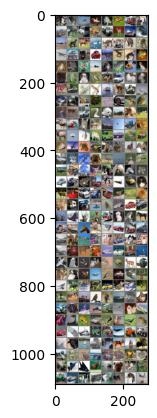

dog   dog   plane horse frog  frog  truck dog   car   deer  car   frog  truck deer  ship  deer  plane dog   horse plane plane car   dog   deer  plane car   cat   car   deer  horse cat   frog  frog  frog  deer  plane bird  frog  dog   dog   cat   frog  dog   bird  horse truck dog   dog   horse car   plane plane ship  deer  truck plane car   truck cat   frog  deer  car   deer  bird  bird  deer  car   bird  dog   plane dog   horse deer  ship  cat   horse plane plane truck deer  deer  plane frog  horse truck plane bird  frog  frog  plane frog  frog  cat   frog  horse dog   car   deer  plane frog  bird  ship  bird  deer  plane cat   car   deer  horse dog   horse frog  car   car   frog  truck horse plane car   dog   deer  car   car   car   truck bird  deer  dog   cat   truck car   ship  bird  frog  car   car   plane truck deer  dog   truck dog   cat   horse truck ship  horse cat   plane car   truck truck plane horse horse horse dog   car   dog   dog   plane car   horse bird  ship  ship  car 

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
from tqdm import tqdm

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

num_epoch = 10
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

#Train
loss_arr = []
accuracy_arr = []

for i in range(num_epoch):

    total_accuracy = 0.0

    for j,[image,label] in enumerate(tqdm(trainloader, desc=f'Epoch {i+1}/{num_epoch}')):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, y_)
        total_accuracy += batch_accuracy

    avg_accuracy = total_accuracy / len(trainloader)
    accuracy_arr.append(avg_accuracy)

    print(f'Epoch {i+1}/{num_epoch}, Loss: {loss}, Train Accuracy: {avg_accuracy * 100:.2f}%')
    loss_arr.append(loss.cpu().detach().numpy())

model_path = 'Mobilev1.pth'

torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_arr,
    }, model_path)

Epoch 1/10: 100%|██████████| 196/196 [00:10<00:00, 19.35it/s]


Epoch 1/10, Loss: 1.6538426876068115, Train Accuracy: 27.81%


Epoch 2/10: 100%|██████████| 196/196 [00:10<00:00, 19.56it/s]


Epoch 2/10, Loss: 1.4849019050598145, Train Accuracy: 42.57%


Epoch 3/10: 100%|██████████| 196/196 [00:10<00:00, 19.25it/s]


Epoch 3/10, Loss: 1.404420256614685, Train Accuracy: 50.40%


Epoch 4/10: 100%|██████████| 196/196 [00:10<00:00, 19.56it/s]


Epoch 4/10, Loss: 1.2672090530395508, Train Accuracy: 55.71%


Epoch 5/10: 100%|██████████| 196/196 [00:09<00:00, 19.62it/s]


Epoch 5/10, Loss: 1.1159394979476929, Train Accuracy: 60.23%


Epoch 6/10: 100%|██████████| 196/196 [00:10<00:00, 19.55it/s]


Epoch 6/10, Loss: 0.8829430341720581, Train Accuracy: 63.47%


Epoch 7/10: 100%|██████████| 196/196 [00:10<00:00, 19.45it/s]


Epoch 7/10, Loss: 1.0677353143692017, Train Accuracy: 66.14%


Epoch 8/10: 100%|██████████| 196/196 [00:09<00:00, 19.62it/s]


Epoch 8/10, Loss: 1.1303911209106445, Train Accuracy: 69.27%


Epoch 9/10: 100%|██████████| 196/196 [00:10<00:00, 19.48it/s]


Epoch 9/10, Loss: 0.948956310749054, Train Accuracy: 71.70%


Epoch 10/10: 100%|██████████| 196/196 [00:10<00:00, 19.53it/s]

Epoch 10/10, Loss: 0.8760088086128235, Train Accuracy: 74.33%


In [9]:
model_path = 'Mobilev1.pth'

model = mobilenetv1().to(device)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

acc = []

with torch.no_grad():
    for image, label in testloader:
        x = image.to(device)
        y_ = label.to(device)
        output = model(x)
        
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == y_).sum().item() / len(y_)
        acc.append(accuracy)
    print(f'Test Accuracy: {max(acc) * 100:.2f}%')

Test Accuracy: 81.25%
